<a href="https://colab.research.google.com/github/AISEN312/first-contributions/blob/main/PhotolyticConversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Read the data
df = pd.read_csv('/content/tabular-lstm-evaluate-671d0c61cbaeaaff2919d4a6-data_preview.csv')
print("Dataset shape:", df.shape)
print("\
First few rows of the dataset:")
print(df.head())

Dataset shape: (5000, 6)
First few rows of the dataset:
             material name      synthesis method    types of defect  \
0            Rhodium Oxide          Hydrothermal  Holmium Vacancies   
1            Yttrium Oxide  Magnetron Sputtering     Zinc Vacancies   
2         Molybdenum Oxide  Magnetron Sputtering  Yttrium Vacancies   
3           Europium Oxide  Precipitation Method  Holmium Vacancies   
4  Cerium Oxide (Zr-doped)          Hydrothermal  Holmium Vacancies   

   band gap energy  defevt concentration  photolytic activity  
0              1.9                  0.27             1.000000  
1             95.8                  5.04             1.000000  
2             38.9                  4.29             1.000000  
3              1.9                  1.90             0.995386  
4             95.8                  5.04             1.000000  


In [2]:
# Prepare data for modeling
# Convert categorical variables to numerical using LabelEncoder
le = LabelEncoder()
df['material_name_encoded'] = le.fit_transform(df['material name'])
df['synthesis_method_encoded'] = le.fit_transform(df['synthesis method'])
df['defect_type_encoded'] = le.fit_transform(df['types of defect'])

# Prepare features and target
X = df[['material_name_encoded', 'synthesis_method_encoded', 'defect_type_encoded',
        'band gap energy', 'defevt concentration']]
y = df['photolytic activity']

lr_model = LinearRegression()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Dictionary of Models
models = {
    'LinearRegression': lr_model,
    'RandomForest': rf_model,
    'LSTM': build_lstm_model((X.shape[1], 1))
}

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
results = {}



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [3]:
from sklearn.metrics import r2_score

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
results = {}

# Evaluate Models
for name, model in models.items():
    train_scores = []
    test_scores = []
    rmse_scores = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_test_scaled = scaler.transform(X_test_fold)

        if name == 'LSTM':
            # Reshape for LSTM
            X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
            X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

            # Train and predict
            model.fit(X_train_scaled, y_train_fold, epochs=10, batch_size=32, verbose=0)

            # Predictions on train and test sets
            y_train_pred = model.predict(X_train_scaled).flatten()
            y_test_pred = model.predict(X_test_scaled).flatten()

            # Calculate Train and Test R² scores for LSTM
            train_score = r2_score(y_train_fold, y_train_pred)
            test_score = r2_score(y_test_fold, y_test_pred)
            rmse = np.sqrt(mean_squared_error(y_test_fold, y_test_pred))

            train_scores.append(train_score)
            test_scores.append(test_score)
            rmse_scores.append(rmse)

        else:
            # Train and evaluate for non-LSTM
            model.fit(X_train_scaled, y_train_fold)
            train_score = model.score(X_train_scaled, y_train_fold)
            test_score = model.score(X_test_scaled, y_test_fold)
            y_pred = model.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))

            train_scores.append(train_score)
            test_scores.append(test_score)
            rmse_scores.append(rmse)

    # Store results for the current model
    results[name] = {
        'train_scores': train_scores,
        'test_scores': test_scores,
        'rmse_scores': rmse_scores
    }

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [4]:
    print(f"\n{name} Results:")
    print(f"Average Train Score: {np.mean(train_scores):.4f}")
    print(f"Average Test Score: {np.mean(test_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")


LSTM Results:
Average Train Score: -0.0942
Average Test Score: -0.1094
Average RMSE: 0.0282


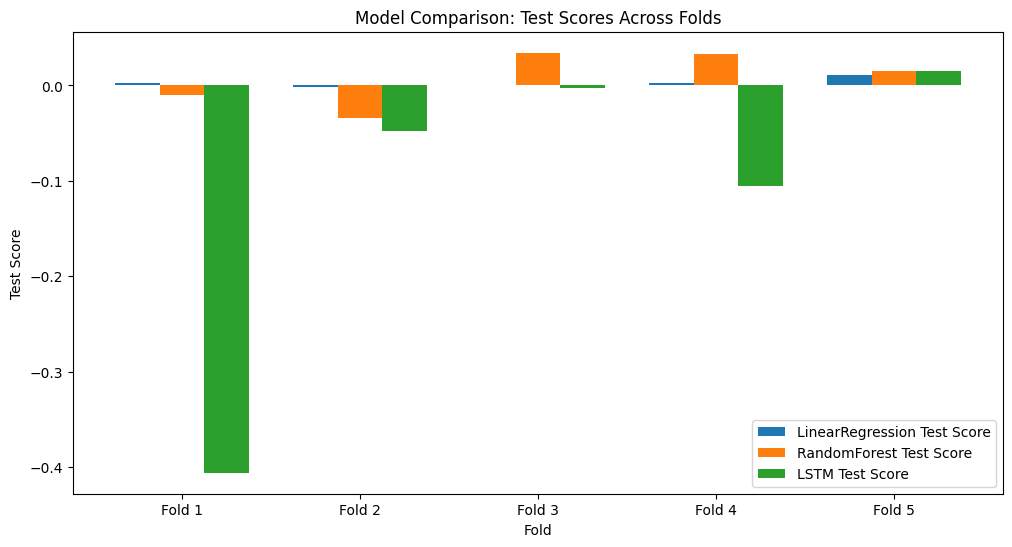

In [5]:
x = np.arange(5)
width = 0.25

# Test Score Comparison Plot
plt.figure(figsize=(12, 6))
for i, (name, result) in enumerate(results.items()):
    plt.bar(x + i * width, [score if not np.isnan(score) else 0 for score in result['test_scores']],
            width, label=f'{name} Test Score')
plt.xlabel('Fold')
plt.ylabel('Test Score')
plt.title('Model Comparison: Test Scores Across Folds')
plt.legend()
plt.xticks(x + width, [f'Fold {i+1}' for i in range(5)])
plt.show()


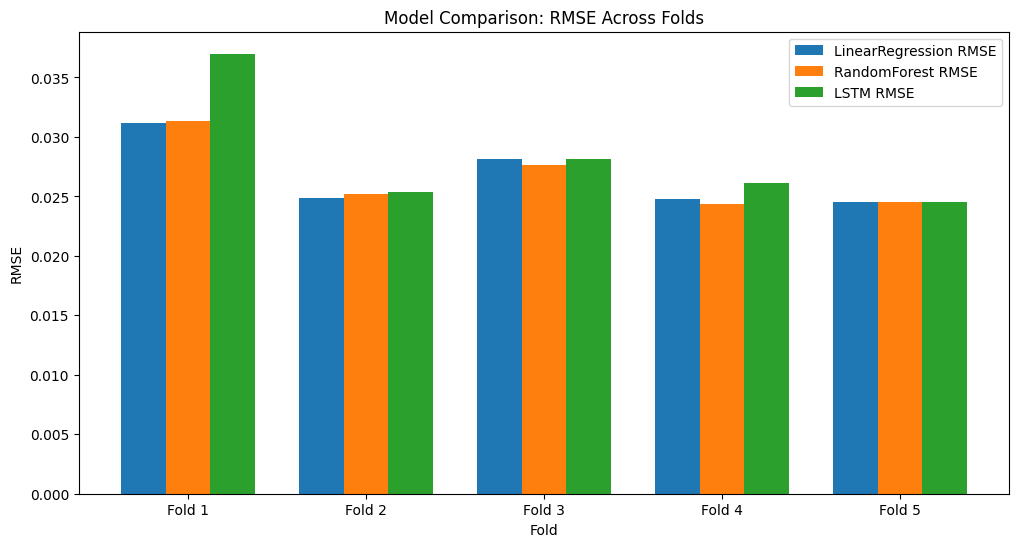

In [6]:
# RMSE Comparison Plot
plt.figure(figsize=(12, 6))
for i, (name, result) in enumerate(results.items()):
    plt.bar(x + i * width, result['rmse_scores'], width, label=f'{name} RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Model Comparison: RMSE Across Folds')
plt.legend()
plt.xticks(x + width, [f'Fold {i+1}' for i in range(5)])
plt.show()

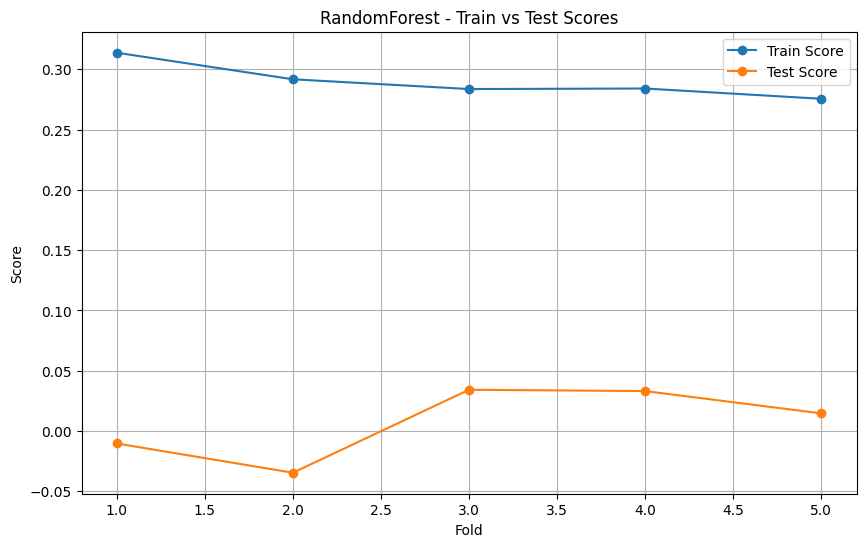

In [7]:
best_model_name = max(results.items(), key=lambda x: np.nanmean(x[1]['test_scores']))[0]
plt.figure(figsize=(10, 6))

if best_model_name != 'LSTM':
    plt.plot(range(1, 6), results[best_model_name]['train_scores'], 'o-', label='Train Score')
    plt.plot(range(1, 6), results[best_model_name]['test_scores'], 'o-', label='Test Score')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title(f'{best_model_name} - Train vs Test Scores')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("LSTM is the best model")

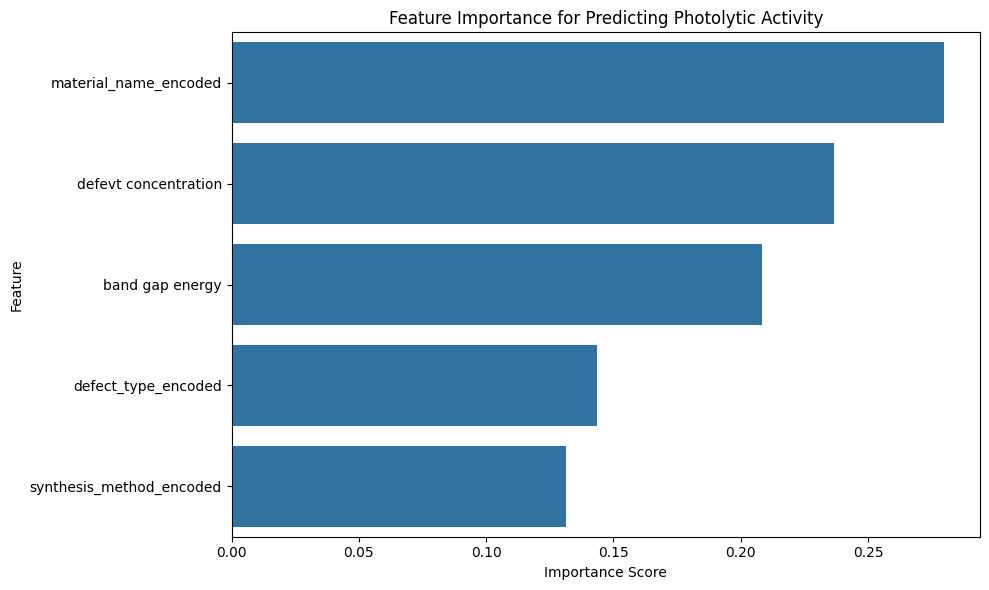

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()
df['material_name_encoded'] = le.fit_transform(df['material name'])
df['synthesis_method_encoded'] = le.fit_transform(df['synthesis method'])
df['defect_type_encoded'] = le.fit_transform(df['types of defect'])

# Select features and target variable
X = df[['material_name_encoded', 'synthesis_method_encoded', 'defect_type_encoded',
        'band gap energy', 'defevt concentration']]
y = df['photolytic activity']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


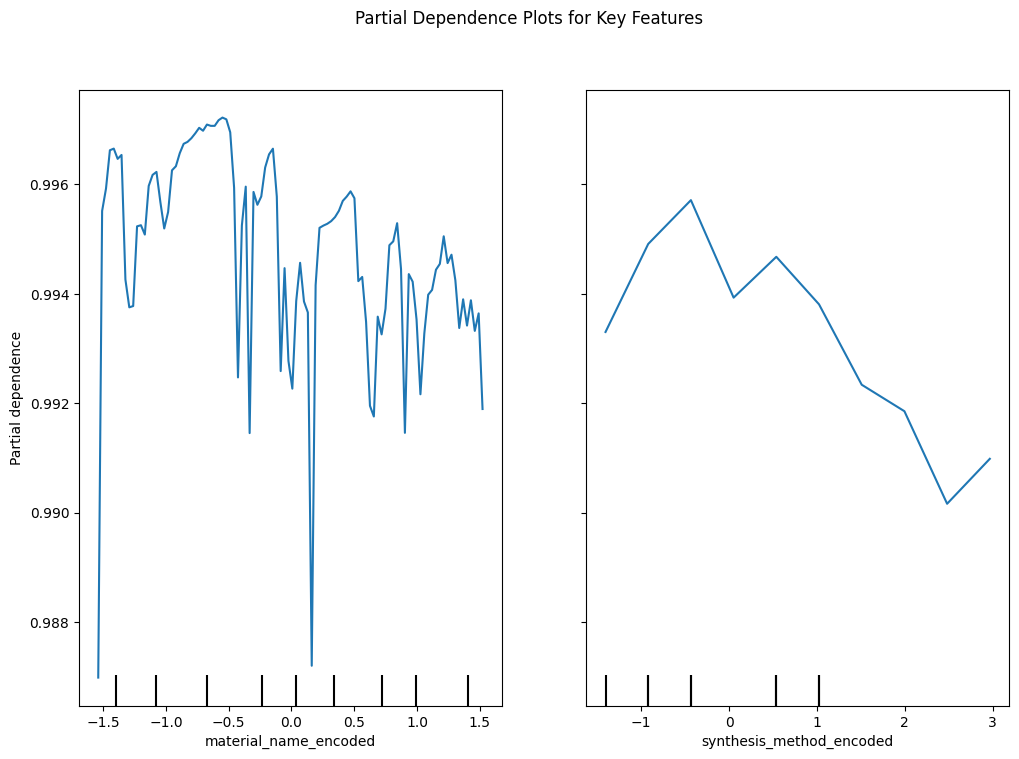

In [9]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Create a Partial Dependence Plot for the most important features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X_train_scaled, [0, 1], ax=ax,
                                        feature_names=feature_names)
plt.suptitle('Partial Dependence Plots for Key Features')
plt.show()


In [10]:
import numpy as np

# Define the range of values for the most important features
material_range = np.linspace(X['material_name_encoded'].min(), X['material_name_encoded'].max(), 10)
synthesis_range = np.linspace(X['synthesis_method_encoded'].min(), X['synthesis_method_encoded'].max(), 10)
band_gap_range = np.linspace(X['band gap energy'].min(), X['band gap energy'].max(), 10)
defect_concentration_range = np.linspace(X['defevt concentration'].min(), X['defevt concentration'].max(), 10)

# Generate all combinations of values for these features
synthetic_data = []
for material in material_range:
    for synthesis in synthesis_range:
        for band_gap in band_gap_range:
            for defect_concentration in defect_concentration_range:
                synthetic_data.append([material, synthesis, 0, band_gap, defect_concentration])  # 0 as a placeholder for 'defect type'

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=feature_names)

# Scale synthetic data using the previously fitted scaler
synthetic_scaled = scaler.transform(synthetic_df)

# Predict photolytic activity for synthetic data
synthetic_df['predicted_photolytic_activity'] = rf_model.predict(synthetic_scaled)

# Find the top 10 combinations with highest predicted photolytic activity
top_combinations = synthetic_df.sort_values(by='predicted_photolytic_activity', ascending=False).head(10)
print("Top 10 feature combinations for high photolytic activity:")
print(top_combinations)


Top 10 feature combinations for high photolytic activity:
      material_name_encoded  synthesis_method_encoded  defect_type_encoded  \
3207             124.333333                       2.0                    0   
2207              82.888889                       2.0                    0   
2247              82.888889                       2.0                    0   
2248              82.888889                       2.0                    0   
3106             124.333333                       1.0                    0   
3107             124.333333                       1.0                    0   
3206             124.333333                       2.0                    0   
2206              82.888889                       2.0                    0   
2106              82.888889                       1.0                    0   
2107              82.888889                       1.0                    0   

      band gap energy  defevt concentration  predicted_photolytic_activity  
3207  